In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, accuracy_score

In [2]:
def make_dictionary(root_dir):
    all_words = []
    emails = [os.path.join(root_dir, f) for f in os.listdir(root_dir)]
    for mail in emails:
        with open(mail) as m:
            for line in m:
                words = [word for word in line.split() if word.isalpha() == True or len(word) > 1] #got rid of second for loop, adding parameters into list comprehension
                all_words.extend(words) #instead of creating new list each time, just extending all_words
    dictionary = Counter(all_words).most_common(3000) #getting count and subsetting for most common at same time
    return dictionary

In [3]:
def extract_features(mail_dir):
    files = [os.path.join(mail_dir,fi) for fi in os.listdir(mail_dir)]
    features_matrix = np.zeros((len(files),3000))
    train_labels = np.zeros(len(files))
    for docID, fil in enumerate(files): # instead of setting docID to zero then incrementing, putting as part of for loop
        with open(fil) as fi:
            for i, line in enumerate(fi):
                if i == 2:
                    words = line.split()
                    word_counts = Counter(words) #instead of recalculating the count of words everytime, store it beforehand
                    for word, count in word_counts.items():
                        for wordID, d in enumerate(dictionary):
                            if d[0] == word:
                                features_matrix[docID, wordID] = count
                                break
        filepathTokens = fil.split('/')
        lastToken = filepathTokens[len(filepathTokens) - 1]
        train_labels[docID] = 1 if lastToken.startswith('spmsg') else 0 #if statements put into 1 line

    return features_matrix, train_labels

In [4]:
TRAIN_DIR = '/Users/tommyropp/Desktop/MSBA/Semester Two/BSAN 6070/bsan_6070/CA 02/Data/train-mails'
TEST_DIR = '/Users/tommyropp/Desktop/MSBA/Semester Two/BSAN 6070/bsan_6070/CA 02/Data/test-mails'

In [5]:
dictionary = make_dictionary(TRAIN_DIR)

print ("reading and processing emails from TRAIN and TEST folders")
features_matrix, labels = extract_features(TRAIN_DIR)
test_features_matrix, test_labels = extract_features(TEST_DIR)

# processing time down to 10 seconds vs. over a minute before

reading and processing emails from TRAIN and TEST folders


Training Model using Multinomial Naïve Bayes algorithm .....
Training completed
Testing trained model to predict Test Data labels
Completed classification of the Test Data .... now printing Accuracy Score by comparing the Predicted Labels with the Test Labels:
0.9576923076923077
AUC: 0.9975739644970415
Gini Coefficient: 0.995147928994083


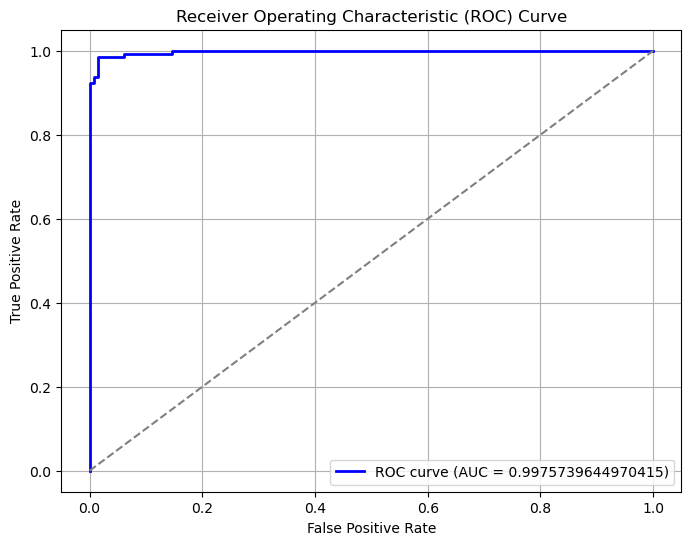

0.14423076923076922
0.8807692307692306


In [11]:
print("Training Model using Multinomial Naïve Bayes algorithm .....")
model = MultinomialNB()
model.fit(features_matrix, labels)
print("Training completed")

print("Testing trained model to predict Test Data labels")
predicted_labels = model.predict(test_features_matrix)
predicted_probs = model.predict_proba(test_features_matrix)[:, 1] #Getting probabilities for positive class
print("Completed classification of the Test Data .... now printing Accuracy Score by comparing the Predicted Labels with the Test Labels:")
accuracy = accuracy_score(test_labels, predicted_labels)
print(accuracy)

#Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, predicted_probs) #computer false and true positive rate, _ ignores the third value returned by roc_curve()
roc_auc = auc(fpr, tpr)

# Compute Gini Coefficient
gini_coefficient = 2 * roc_auc - 1
print(f"AUC: {roc_auc}")
print(f"Gini Coefficient: {gini_coefficient}")

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
sorted_indices = np.argsort(-predicted_probs) # sorting predicted probs in descending order
sorted_probs = predicted_probs[sorted_indices]
sorted_labels = test_labels[sorted_indices]

#first sort the predicted probabilities

tpr_values = []
fpr_values = []

total_positives = sum(test_labels)
total_negatives = len(test_labels) - total_positives
tp, fp = 0,0

for i in range(len(sorted_probs)):
    if sorted_labels[i] == 1:
        tp += 1
    else:
        fp += 1
    
    tpr = tp/total_positives
    fpr = fp/total_negatives

    tpr_values.append(tpr)
    fpr_values.append(fpr)

auc_value = np.trapz(tpr_values, fpr_values)